# Wiring Diagrams as Attributed C-Sets
Catlab supports many different flavors of diagrammatic syntax. These support the different combinatorial data structures that we use for representing categorical constructions. We will discuss DirectedWiringDiagrams, UndirectedWiringDiagrams, and CPortGraphs in this document.

In [1]:
using Catlab, Catlab.Theories
using Catlab.CategoricalAlgebra
using Catlab.WiringDiagrams
using Catlab.Graphics
using Catlab.Graphics.Graphviz
using Catlab.Programs
using Catlab.WiringDiagrams

draw(d::WiringDiagram) = to_graphviz(d,
  orientation=LeftToRight,
  labels=true, label_attr=:xlabel,
  node_attrs=Graphviz.Attributes(
    :fontname => "Courier",
  ),
  edge_attrs=Graphviz.Attributes(
    :fontname => "Courier",
  )
)

draw(uwd::AbstractUWD) = to_graphviz(uwd, junction_labels=:variable, box_labels=:name)

draw (generic function with 2 methods)

## Directed Wiring Diagrams

DWDs are used to represent the morphisms in a symmetric monoidal category. You can get started by presenting a `FreeSymmetricMonoidalCategory` with the `@present` macro.

In [2]:
@present P(FreeSymmetricMonoidalCategory) begin
  (A,B,C,D)::Ob
  f::Hom(A,B)
  g::Hom(B,A)
  h::Hom(A⊗B, C)
  k::Hom(C,D⊗A)
end
generators(P)

8-element Vector{Any}:
 A
 B
 C
 D
 f: A → B
 g: B → A
 h: A⊗B → C
 k: C → D⊗A

These presentations are very syntactic objects and expose an API for manipulating expressions.

In [3]:
for g in generators(P)
  "$g is a $(gat_typeof(g)) with arguments $(gat_type_args(g))"
end

The `gat_typeof` function computes the algebraic type of a term by analogy to `Base.typeof` which computes the Julia type of a value.

In [4]:
homs_P = filter(generators(P)) do g
  gat_typeof(g) == :Hom
end

4-element Vector{Any}:
 f: A → B
 g: B → A
 h: A⊗B → C
 k: C → D⊗A

When the term is a Hom, you can get the domain and codomain of the morphism with the `dom` and `codom` functions.

In [5]:
map(homs_P) do f
  "$f: $(dom(f)) → $(codom(f))"
end

4-element Vector{String}:
 "f: A → B"
 "g: B → A"
 "h: otimes(A,B) → C"
 "k: C → otimes(D,A)"

With the presentation you can build up morphism expressions using a formula syntax.

In [6]:
P[:h]⋅P[:k]

h⋅k: A⊗B → D⊗A

This syntactic API is useful for manipulating terms in an arbitrary GAT and is the formal language of Catlab for representing and manipulating algebraic structures.
However, when we want to work with big expressions in an SMC, the tree structure inherent to formulas is too verbose, and we want to move to a port-graph structure called `DirectedWiringDiagrams`. This gives us the benefits of combinatorial data structures like graphs with the right expressional power for representing the morphisms in an SMC.

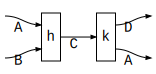

In [7]:
wd = @program P (a::A, b::B) begin
  c = h(a,b)
  return k(c)
end

draw(wd)

Catlab gives you the tools for drawing wiring diagrams. Visualization of wiring diagrams is the oldest part of Catlab and the original motivation for its development. The `@program` macro allows you to define wiring diagrams using a syntax that feels like Julia code.

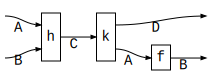

In [8]:
wd = @program P (a::A, b::B) begin
  c = h(a,b)
  d,a₁ = k(c)
  return d, f(a₁)
end
draw(wd)

The input wires are declared as *arguments* to the program, and the output wires are declared as *returns* from the function. Variables that are not consumed or by another function or returned by the program are automatically dropped.

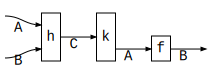

In [9]:
wd = @program P (a::A, b::B) begin
  c = h(a,b)
  d,a₁ = k(c)
  return f(a₁)
end
draw(wd)

You can copy a value by using it more than once. This is visualized as a wire being split into two wires.

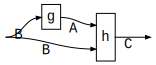

In [10]:
wd = @program P (b::B) begin
  h(g(b),b)
end
draw(wd)

You can visualize the copy and delete morphisms explicitly with the `add_junctions` function. The dots with one wire input and multiple outputs are copying values and dots with no wires out are deletions (discarding values). Not all instances of a `SymmetricMonoidalCategory` support copy and delete, for example, in manufacturing you can't duplicate a resource, and in chemistry you can't discard species. Catlab would enforce that when you tried to interpret the wiring diagram in a specific SMC.

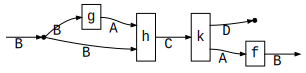

In [11]:
wd = @program P (b::B) begin
  c = h(g(b),b)
  d, a₁ = k(c)
  return f(a₁)
end
draw(add_junctions(wd))

For more details about working with wiring diagrams in Catlab, you should look at the other vignettes in this section which explain how wiring diagrams interact with SMC expressions and the basics of constructing and manipulation wiring diagrams.

## Diagrams as C-Sets

The underlying data of a wiring diagram is combinatorial. That means we can represent it as a C-Set

In [12]:
wd.diagram

Box,value,box_type
1,g,Box{Symbol}
2,h,Box{Symbol}
3,k,Box{Symbol}
4,f,Box{Symbol}
InPort,in_port_box,in_port_type
1,1,B
2,2,A
3,2,B
4,3,C
5,4,A


Ok, there is a lot in there. The columns with integer entries are the combinatorial data encoding the connectivity of the wiring diagram. The columns with Symbols in them are encoding the labels for the diagram, the `value` of a box is the content of the box. Ports have types and wires have values. When we define the wiring diagram with the `@program` macro, we get a diagram that has labels and types, but no values. These values are initialized to nothing, but could be filled with values to be carried down the wires in an application.

The schema of for wiring diagrams is called TheoryAttributedWiringDiagrams and is a little overwhelming, so we can explore how to build it up with C-Set schema inheritance.

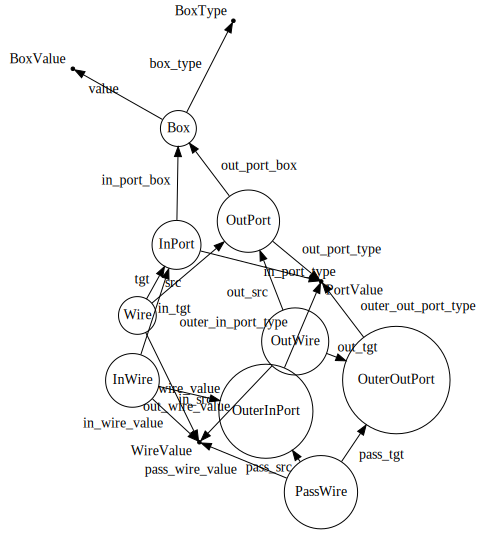

In [13]:
to_graphviz(WiringDiagrams.DirectedWiringDiagrams.TheoryAttributedWiringDiagram)

From the file Catlab/src/WiringDiagrams/Directed.jl
```julia
@present TheoryWiringDiagram(FreeSchema) begin
  Box::Ob
  (InPort, OutPort, OuterInPort, OuterOutPort)::Ob
  (Wire, InWire, OutWire, PassWire)::Ob

  src::Hom(Wire, OutPort)
  tgt::Hom(Wire, InPort)
  in_src::Hom(InWire, OuterInPort)
  in_tgt::Hom(InWire, InPort)
  out_src::Hom(OutWire, OutPort)
  out_tgt::Hom(OutWire, OuterOutPort)
  pass_src::Hom(PassWire, OuterInPort)
  pass_tgt::Hom(PassWire, OuterOutPort)

  in_port_box::Hom(InPort, Box)
  out_port_box::Hom(OutPort, Box)
end

@abstract_acset_type AbstractWiringDiagram <: AbstractGraph

@present TheoryTypedWiringDiagram <: TheoryWiringDiagram begin
  PortValue::AttrType
  in_port_type::Attr(InPort, PortValue)
  out_port_type::Attr(OutPort, PortValue)
  outer_in_port_type::Attr(OuterInPort, PortValue)
  outer_out_port_type::Attr(OuterOutPort, PortValue)
end

@present TheoryAttributedWiringDiagram <: TheoryTypedWiringDiagram begin
  WireValue::AttrType
  BoxValue::AttrType
  BoxType::AttrType

  value::Attr(Box, BoxValue)
  box_type::Attr(Box, BoxType)
  wire_value::Attr(Wire, WireValue)
  in_wire_value::Attr(InWire, WireValue)
  out_wire_value::Attr(OutWire, WireValue)
  pass_wire_value::Attr(PassWire, WireValue)
end
```

The bare minimum diagram language is:

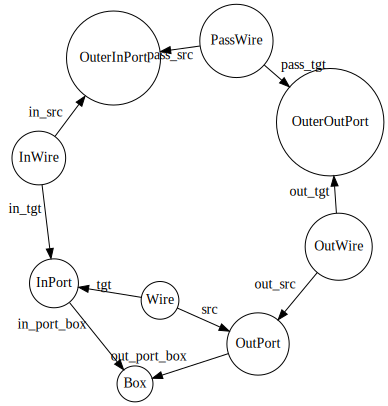

In [14]:
to_graphviz(WiringDiagrams.DirectedWiringDiagrams.TheoryWiringDiagram)

And then you can add back in the types.

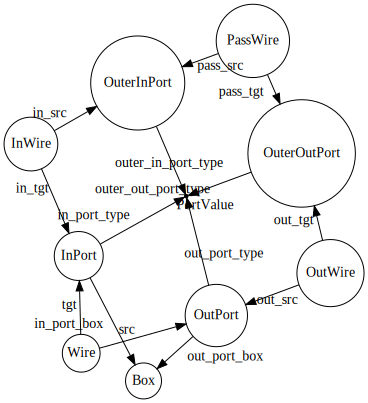

In [15]:
to_graphviz(WiringDiagrams.DirectedWiringDiagrams.TheoryTypedWiringDiagram)

#Layout is hard, so if you want to understand the `TheoryAttributedWiringDiagrams`, you should do the layout by hand as an exercise.

We can create our own version of the theory of DWDs to see how it works:

In [16]:
@present MyTheoryWiringDiagram(FreeSchema) begin
  Box::Ob
  (InPort, OutPort, OuterInPort, OuterOutPort)::Ob
  (Wire, InWire, OutWire, PassWire)::Ob

  src::Hom(Wire, OutPort)
  tgt::Hom(Wire, InPort)
  in_src::Hom(InWire, OuterInPort)
  in_tgt::Hom(InWire, InPort)
  out_src::Hom(OutWire, OutPort)
  out_tgt::Hom(OutWire, OuterOutPort)
  pass_src::Hom(PassWire, OuterInPort)
  pass_tgt::Hom(PassWire, OuterOutPort)

  in_port_box::Hom(InPort, Box)
  out_port_box::Hom(OutPort, Box)
end

Presentation{Schema, Symbol}(Catlab.Theories.FreeSchema, (Ob = Catlab.Theories.FreeSchema.Ob{:generator}[Box, InPort, OutPort, OuterInPort, OuterOutPort, Wire, InWire, OutWire, PassWire], Hom = Catlab.Theories.FreeSchema.Hom{:generator}[src, tgt, in_src, in_tgt, out_src, out_tgt, pass_src, pass_tgt, in_port_box, out_port_box], AttrType = Catlab.Theories.FreeSchema.AttrType{:generator}[], Attr = Catlab.Theories.FreeSchema.Attr{:generator}[]), Dict(:InPort => (:Ob => 2), :InWire => (:Ob => 7), :in_port_box => (:Hom => 9), :Box => (:Ob => 1), :OuterOutPort => (:Ob => 5), :in_src => (:Hom => 3), :in_tgt => (:Hom => 4), :src => (:Hom => 1), :OuterInPort => (:Ob => 4), :out_port_box => (:Hom => 10)…), Pair[])

If your application of wiring diagrams needs to attach numeric or textual information to the boxes of a wiring diagram, you would extend the `TheoryWiringDiagram` with the attributes that you need. That will give you a custom data structure that has those fields. One of the goals of Catlab is to make it so much easier to generate custom data structures that interoperate, that you don't need to create generic structures that can be used for many purposes. Just snap your fingers and create a new structure perfectly tailored to your needs, when your needs change, snap again to get a new version of that structure.

The `@acset_type` macro does the hard work of generating the data structure and accessors and mutators for you. The form of this call is `@acset_type NewStructName(Schema, index=[morphisms in Schema]) <: Supertype`. You should index any morphism where you need to use `incident` frequently. For wiring diagrams you will often want to know what all the wires that are incident to a port.

In [17]:
@acset_type MyWiringDiagramACSet(MyTheoryWiringDiagram,
  index=[:src, :tgt, :in_src, :in_tgt, :out_src, :out_tgt, :pass_src, :pass_tgt]) <: WiringDiagrams.DirectedWiringDiagrams.AbstractWiringDiagram

We get the `@acset` macro from Catlab and can create DWDs by hand. It is very tedious, which is why the `@program` macro exists!

In [18]:
md = @acset MyWiringDiagramACSet begin
  Box = 3
  InPort = 6
  OutPort = 3
  Wire = 3
  src = [1,2,3]
  tgt = [3,4,5]
  in_port_box = [1,1,2,2,3,3]
  out_port_box = [1,2,3]
end

InPort,in_port_box
1,1
2,1
3,2
4,2
5,3
6,3
OutPort,out_port_box
1,1
2,2
3,3


## Undirected Wiring Diagrams
A much simpler structure than DWDs are known as undirected wiring diagrams. They are called undirected because ports boxes have one set of ports that aren't divided into inputs and outputs, and the wires are undirected. Wires connect junctions to ports (which live on boxes).

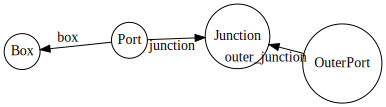

In [19]:
to_graphviz(WiringDiagrams.UndirectedWiringDiagrams.TheoryUWD)

These UWDs are combinatorial syntax for relations. The junctions are variables and the boxes are the relations. A relation R ⊆ X × Y has two ports one for the value of X and one for the value of Y. The expression R(x:X, y:Y) says to connect the X port of R to the junction for the variable x, and the Y port of R to the y variable junction. If two ports are attached to the same junction, then you have a constraint that those values must be equal. The outer ports are the components of the final relation. For example the following UWD encodes the relation {(x,y,z) | R(x,y) and S(y,z) for all x∈X, y∈Y, z∈Z}.

In [20]:
uwd = @relation (x, y, z) begin
  R(x,y)
  S(y,z)
end

Catlab.Programs.RelationalPrograms.UntypedUnnamedRelationDiagram{Symbol, Symbol} with elements Box = 1:2, Port = 1:4, OuterPort = 1:3, Junction = 1:3
┌─────┬──────┐
│ Box │ name │
├─────┼──────┤
│   1 │    R │
│   2 │    S │
└─────┴──────┘
┌──────┬─────┬──────────┐
│ Port │ box │ junction │
├──────┼─────┼──────────┤
│    1 │   1 │        1 │
│    2 │   1 │        2 │
│    3 │   2 │        2 │
│    4 │   2 │        3 │
└──────┴─────┴──────────┘
┌───────────┬────────────────┐
│ OuterPort │ outer_junction │
├───────────┼────────────────┤
│         1 │              1 │
│         2 │              2 │
│         3 │              3 │
└───────────┴────────────────┘
┌──────────┬──────────┐
│ Junction │ variable │
├──────────┼──────────┤
│        1 │        x │
│        2 │        y │
│        3 │        z │
└──────────┴──────────┘

These UWDs are drawn with circular boxes and undirected wires. Note that since all wires go from junction to port, they are not *symmetric* wires.

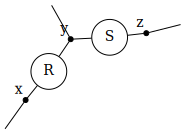

In [21]:
draw(uwd)

By adding more relations we can get bigger relations.

In [22]:
uwd₂ = @relation (x, z) begin
  R(x,y)
  S(y,z)
  T(x,z,y)
end

Catlab.Programs.RelationalPrograms.UntypedUnnamedRelationDiagram{Symbol, Symbol} with elements Box = 1:3, Port = 1:7, OuterPort = 1:2, Junction = 1:3
┌─────┬──────┐
│ Box │ name │
├─────┼──────┤
│   1 │    R │
│   2 │    S │
│   3 │    T │
└─────┴──────┘
┌──────┬─────┬──────────┐
│ Port │ box │ junction │
├──────┼─────┼──────────┤
│    1 │   1 │        1 │
│    2 │   1 │        3 │
│    3 │   2 │        3 │
│    4 │   2 │        2 │
│    5 │   3 │        1 │
│    6 │   3 │        2 │
│    7 │   3 │        3 │
└──────┴─────┴──────────┘
┌───────────┬────────────────┐
│ OuterPort │ outer_junction │
├───────────┼────────────────┤
│         1 │              1 │
│         2 │              2 │
└───────────┴────────────────┘
┌──────────┬──────────┐
│ Junction │ variable │
├──────────┼──────────┤
│        1 │        x │
│        2 │        z │
│        3 │        y │
└──────────┴──────────┘

Not all of the junctions have to be exposed to the outside world. Note that there is no distinction between arguments and return values in the relation macro. This is because relations are inherently undirected, unlike functions.

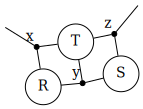

In [23]:
draw(uwd₂)

## Circular Port Graphs
CPGs are the natural data structure for representing process of interconnected systems that share information along wires, but send different information to their different neighbors.

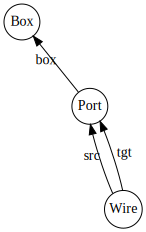

In [24]:
to_graphviz(ThCPortGraph)

They are also a kind of CSet, so we can use the `@acset` macro to construct them.

In [25]:
cpg = @acset CPortGraph begin
  Box = 3
  Port = 6
  Wire = 5

  box = [1,1,2,2,3,3]
  src = [1,2,5,2,6]
  tgt = [3,4,2,4,1]
end

CPortGraph with elements Box = 1:3, Port = 1:6, Wire = 1:5
┌──────┬─────┐
│ Port │ box │
├──────┼─────┤
│    1 │   1 │
│    2 │   1 │
│    3 │   2 │
│    4 │   2 │
│    5 │   3 │
│    6 │   3 │
└──────┴─────┘
┌──────┬─────┬─────┐
│ Wire │ src │ tgt │
├──────┼─────┼─────┤
│    1 │   1 │   3 │
│    2 │   2 │   4 │
│    3 │   5 │   2 │
│    4 │   2 │   4 │
│    5 │   6 │   1 │
└──────┴─────┴─────┘

the layout for CPGs is not great with graphviz.

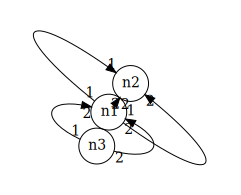

In [26]:
to_graphviz(cpg, port_labels=true, graph_attrs=Dict("nodesep"=>"2", "ranksep"=>"2"))

Almost every application of graphs in computer science could be better served by using one of these extensions to the basic graph data structure.